## Customized QCA Optimizer

In [1]:
# import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import quad
from scipy.stats import zscore
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer
from sklearn import preprocessing
from functools import partial

import matplotlib.pyplot as plt
import random

In [2]:
q_data_ = [np.loadtxt(f'q{i}_t1vsfreq.txt', delimiter=',') for i in range(1, 14)]
q_data = q_data_.copy()
g = [(1,2), 
    (1,13),
    (2,3),
    (2,5),
    (2,4),
    (4,7),
    (4,9),
    (4,13),
    (5,7),
    (6,7),
    (7,8),
    (8,9),
    (9,10),
    (9,11),
    (11,13),
    (12,13)]

D = 0.5
alpha = 0.02
delta_x = 0.005

In [3]:
def filtered_freq_and_time(one_qubit_data):
    freq, time = one_qubit_data[:,0], one_qubit_data[:,1]
    z_scores = zscore(freq)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)  # Keeping data points with Z-score less than 3
    filtered_freq = freq[filtered_entries]
    filtered_time = time[filtered_entries]
    return filtered_freq, filtered_time


def cardinality(g, node):
    count = 0
    for edge in g:
        if node in edge:
            count += 1
    return count


def most_neighbors_node(g, U):
    max_neighbors = 0
    for node in U:
        num_neighbors = cardinality(g, node)
        if num_neighbors >= max_neighbors:
            max_neighbors = num_neighbors
            idx = node
    return idx

def determined_neighbors(g, node, assigned_freqs):
    neighbors = []
    for a, b in g:
        if a == node:
            neighbors.append(b)
        elif b == node:
            neighbors.append(a)
    # print("before filter:", neighbors)     
    neighbors = [n for n in neighbors if n in assigned_freqs.keys()]
    # print("after filter:", neighbors)
    return neighbors


# Next Neighboring constraint

def legal_freq(neighbors, assigned_freqs, freq):
    for node in neighbors:
        diff = abs(assigned_freqs[node] - freq)
        if diff > D or diff < alpha:
            return False
    return True

# def feasible_interval(intervals):
#     max_freq, min_freq = (0, 0)
#     for lb, ub in intervals:
#         if lb > min_freq:
#             min_freq = lb
#         elif ub < max_freq:
#             max_freq = ub
#     if max_freq <= min_freq:
#         return (0, 0)
#     return (min_freq, max_freq)


In [4]:
qdata = {}
for i, one_q in enumerate(q_data.copy()):
    qdata[i+1] = filtered_freq_and_time(one_q)


In [5]:
def freq_placer(g, qdata, order = None, params = (alpha, D)): # index starts at 1
    U = [i for i in qdata.keys()] # nodes to be assigned
    assigned_freq = {}
    assigned_t1 = {}
    exe_order = []

    while U != []:
        if order != None:
            t = order.pop(0)
        else:
            t = most_neighbors_node(g, U)
        # print("t", t)
        exe_order.append(t)
        t_freq_data, t_t1_data = qdata[t]
        if assigned_freq == {}:
            # check if statement
            max_t1 = max(t_t1_data) # can consider multiple solutions
            idx = list(t_t1_data).index(max_t1)
            assigned_freq[t] = t_freq_data[idx]
            assigned_t1[t] = max_t1
        else:
            neighbors = determined_neighbors(g, t, assigned_freq)
            # print("neighbors", neighbors)

            candidate = [] # narrow down candidates
            for freq, t1 in zip(t_freq_data, t_t1_data):
                if legal_freq(neighbors, assigned_freq, freq):
                    candidate.append((freq, t1))
            if candidate == []:
                print("No candidate")
                return
            
            max_t1 = max([t1 for _, t1 in candidate])
            idx = list(t_t1_data).index(max_t1)
            assigned_freq[t] = t_freq_data[idx]
            assigned_t1[t] = max_t1
            
            # idx = list(t_t1_data).index(max(t_t1_data))
            # freq = t_freq_data[idx]
            # while(not legal_freq(neighbors, assigned_freq, freq)):
            #     print("hello")
            #     t_t1_data[idx] = 0
            #     idx = list(t_t1_data).index(max(t_t1_data))
            #     freq = t_freq_data[idx]
            # assigned_freq[t] = freq
            # assigned_t1[t] = t_t1_data[idx]
        
        U.remove(t)
    print("execute order", exe_order)
    return assigned_freq, assigned_t1

In [6]:
results = []
lables = ["edge first", "center first", "random", "corner first"]
freq_1, t1_1 = freq_placer(g, qdata)
results.append((freq_1, t1_1))

freq_2, t1_2 = freq_placer(g, qdata, order = [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12])
results.append((freq_2, t1_2))

U = [i+1 for i in range(len(qdata))]
random.shuffle(U)
results.append(freq_placer(g, qdata, order = U))

res_3 = freq_placer(g, qdata, order = [9, 13, 2, 7, 4, 8, 5, 11, 1, 10, 6, 3, 12])
results.append(res_3)

execute order [13, 9, 7, 4, 2, 11, 8, 5, 1, 12, 10, 6, 3]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [4, 5, 12, 13, 8, 9, 6, 3, 11, 10, 1, 2, 7]
execute order [9, 13, 2, 7, 4, 8, 5, 11, 1, 10, 6, 3, 12]


edge first
sum of t1:  2540.965
sum of t1 * delta x: 12.705 

center first
sum of t1:  2578.771
sum of t1 * delta x: 12.894 

random
sum of t1:  2572.273
sum of t1 * delta x: 12.861 

corner first
sum of t1:  2540.965
sum of t1 * delta x: 12.705 



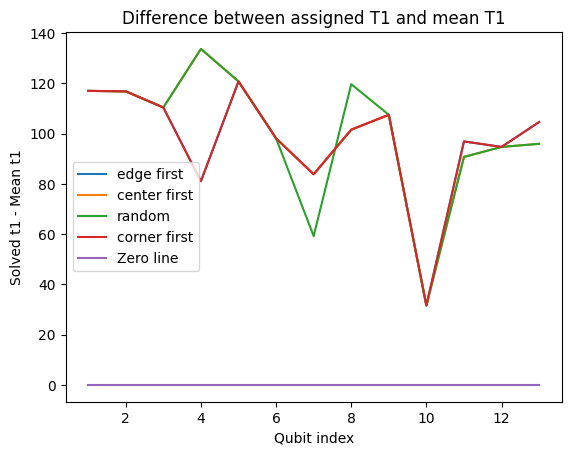

In [7]:
# Visualize results
for i, (assigned_freq, assigned_t1) in enumerate(results):
    x_list = [i+1 for i in range(len(assigned_t1))]
    mean_T1s = {i: np.mean(qdata[i][1]) for i, _ in qdata.items()}

    y_list = [assigned_t1[i+1] - mean_T1s[i+1] for i in range(len(qdata))]
    zero_line = [0 for _ in range(len(qdata))]

    plt.plot(x_list, y_list, label=lables[i])
    print(lables[i])
    print("sum of t1: ", np.round(sum(assigned_t1.values()), 3))
    print("sum of t1 * delta x:", np.round(sum(assigned_t1.values()) * delta_x, 3), "\n")

plt.plot(x_list, zero_line, label="Zero line")

plt.title("Difference between assigned T1 and mean T1")
plt.xlabel("Qubit index")
plt.ylabel("Solved t1 - Mean t1")
plt.legend()
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, '(1, 2)'),
  Text(1, 0, '(1, 13)'),
  Text(2, 0, '(2, 3)'),
  Text(3, 0, '(2, 5)'),
  Text(4, 0, '(2, 4)'),
  Text(5, 0, '(4, 7)'),
  Text(6, 0, '(4, 9)'),
  Text(7, 0, '(4, 13)'),
  Text(8, 0, '(5, 7)'),
  Text(9, 0, '(6, 7)'),
  Text(10, 0, '(7, 8)'),
  Text(11, 0, '(8, 9)'),
  Text(12, 0, '(9, 10)'),
  Text(13, 0, '(9, 11)'),
  Text(14, 0, '(11, 13)'),
  Text(15, 0, '(12, 13)')])

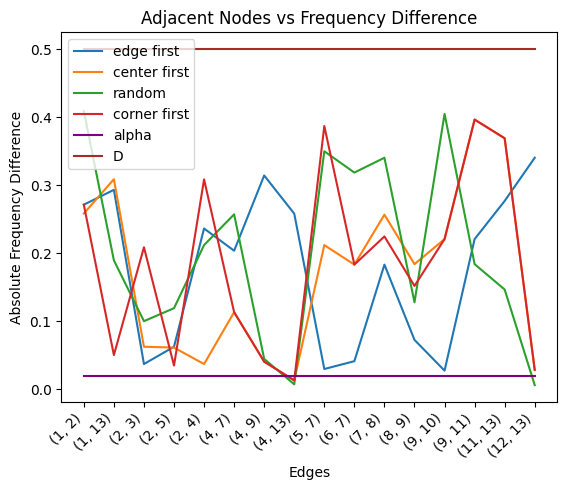

In [8]:
x_labels = [f"({edge[0]}, {edge[1]})" for edge in g]
alpha_line = [alpha for _ in range(len(g))]

D_line = [D for _ in range(len(g))]
for i, (assigned_freq, assigned_t1) in enumerate(results):
    freq = list(assigned_freq.values())
    freq_diff = [abs(freq[j-1] - freq[i-1]) for i, j in g]
    plt.plot(x_labels, freq_diff, label = lables[i])

plt.plot(x_labels, alpha_line, label='alpha', color='purple')
plt.plot(x_labels, D_line, label='D', color='brown')

# Adding labels and title
plt.xlabel('Edges')
plt.ylabel('Absolute Frequency Difference')
plt.title('Adjacent Nodes vs Frequency Difference')

plt.legend()
plt.xticks(rotation=45, ha='right')


In [9]:
pts = []
for i in range(1, 14):
    temp = []
    for freq, t1 in results:
        temp.append([(freq[i], t1[i])])
    pts.append(temp)

print(len(pts))
print(pts[0])

13
[[(np.float64(4.314), np.float64(226.9717))], [(np.float64(4.314), np.float64(226.9717))], [(np.float64(4.314), np.float64(226.9717))], [(np.float64(4.314), np.float64(226.9717))]]


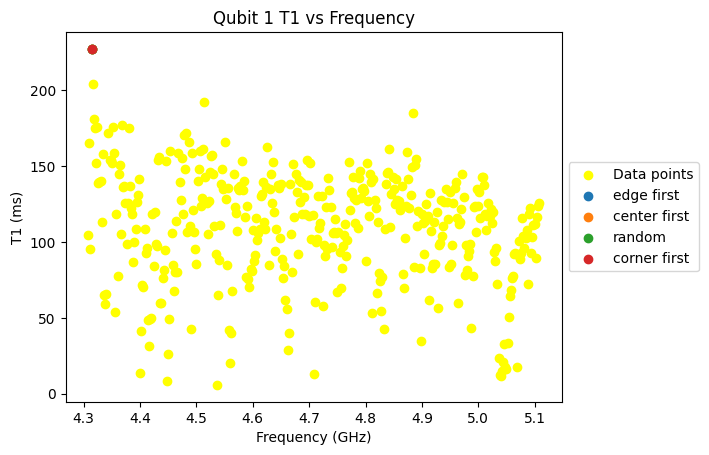

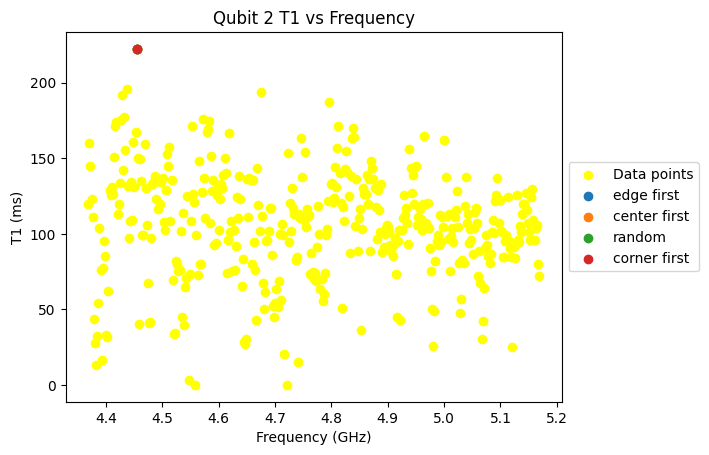

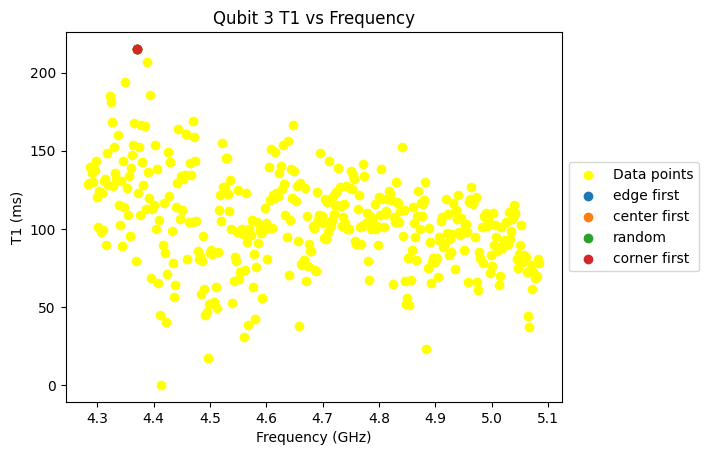

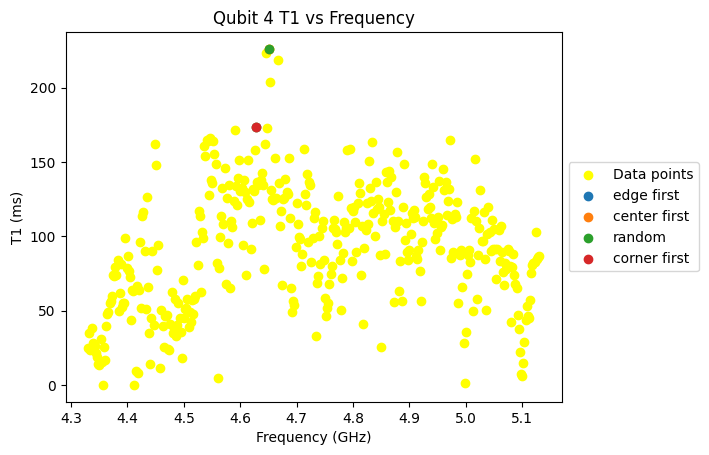

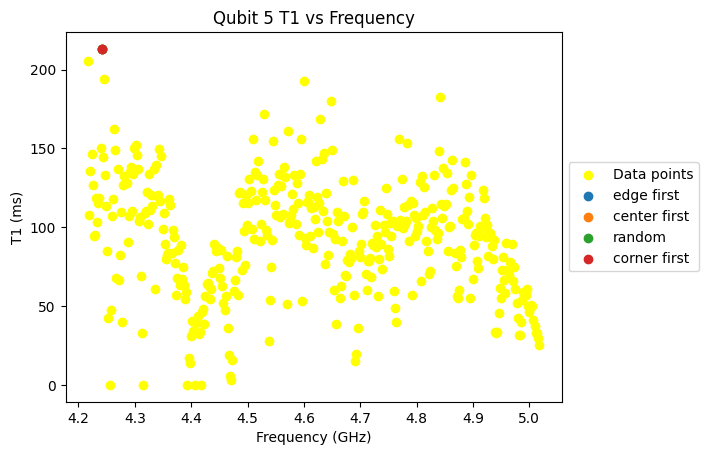

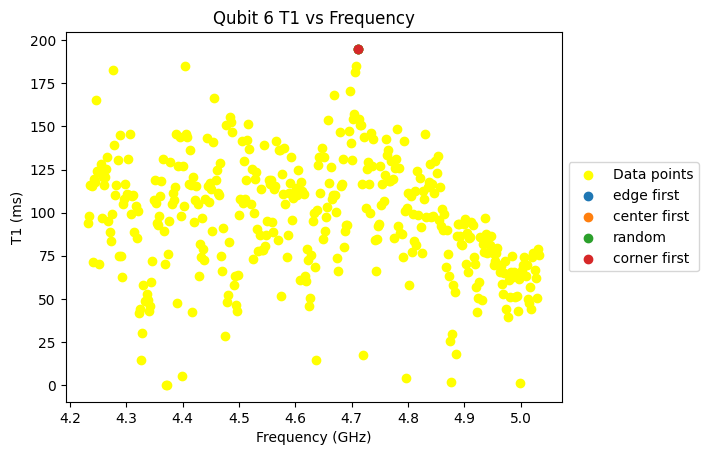

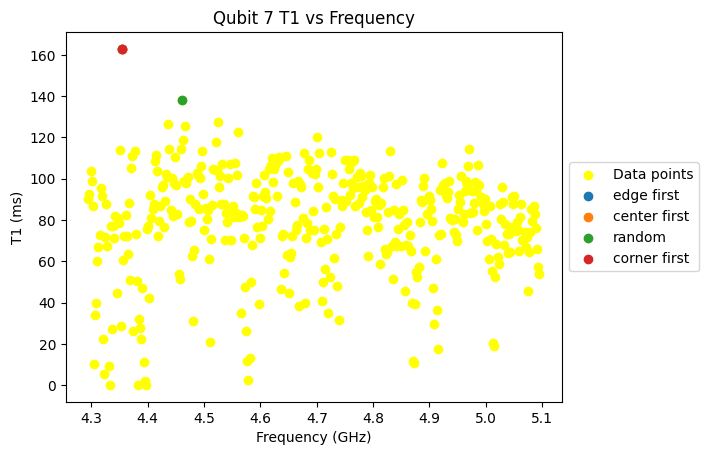

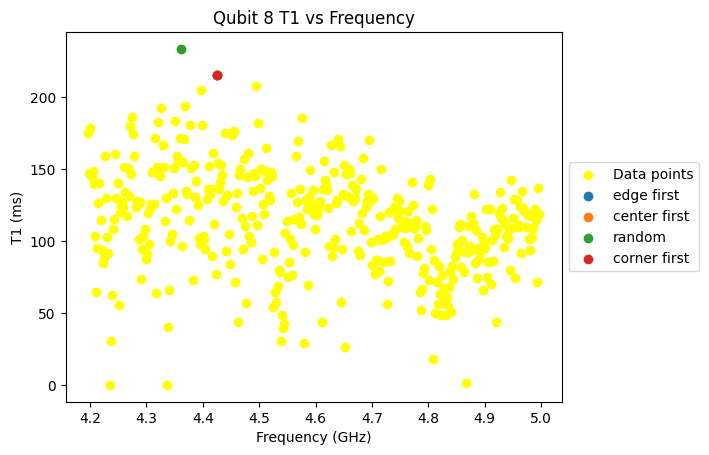

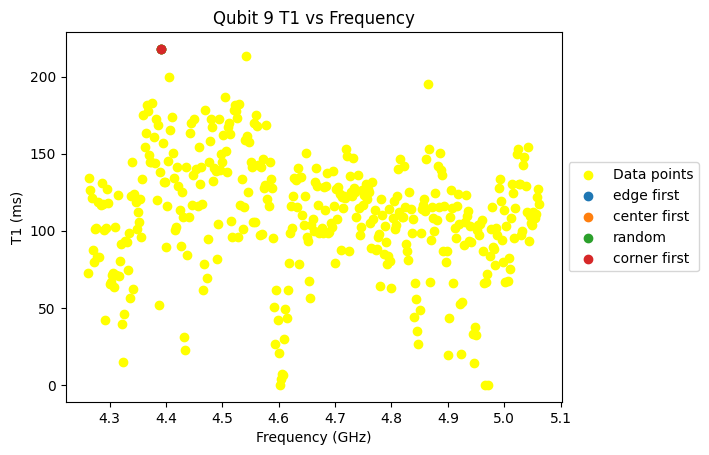

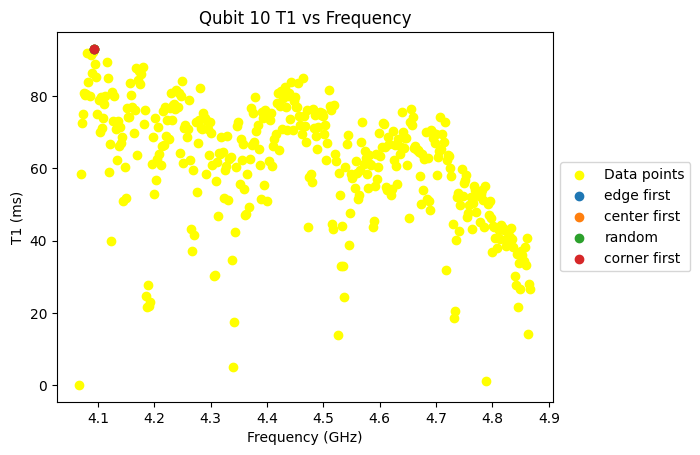

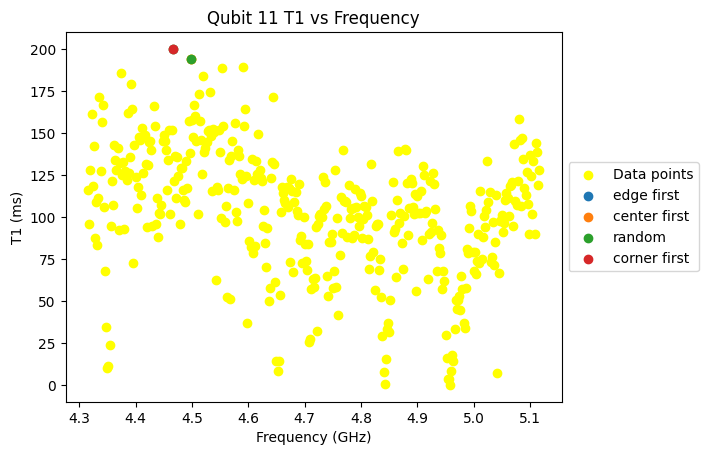

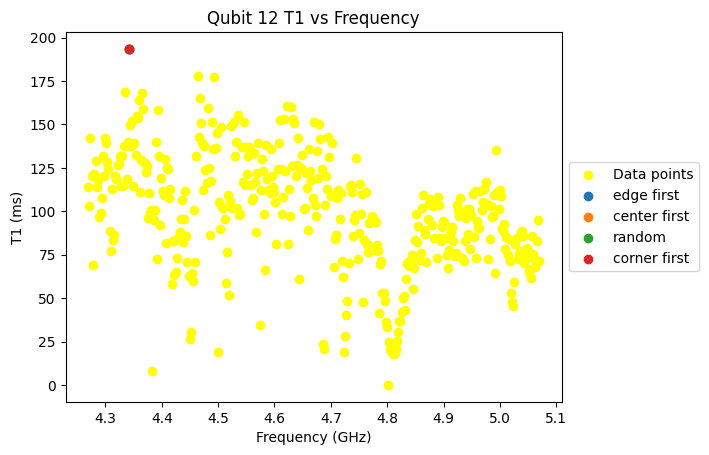

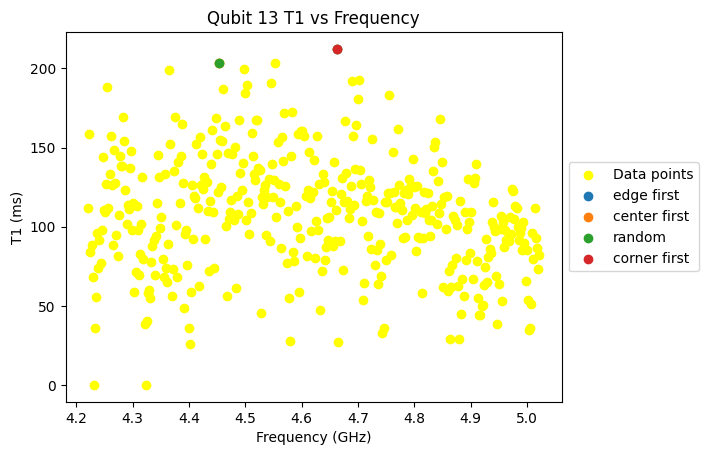

In [10]:
for i in range(13):
    freq, t1 = filtered_freq_and_time(q_data[i])
    # T1_interp = interp1d(freq, t1, kind='cubic', fill_value='extrapolate')

    interp_frequencies = np.linspace(freq.min(), freq.max(), 100)
    # interp_T1_values = T1_interp(interp_frequencies)

    plt.scatter(freq, t1, color='yellow', label='Data points')
    plt.title(f'Qubit {i+1} T1 vs Frequency')

    for i, dots in enumerate(pts[i]):
        plt.scatter(dots[0][0], dots[0][1], label=lables[i])
    # plt.plot(interp_frequencies, interp_T1_values, label='Interpolated curve')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('T1 (ms)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # delta_x = 0.01, take average of t1 values
    
    # edge to center strategy
    # beam search
    # optimize 5 as a group


    # small improvement
    # candidate = range

In [11]:
assigned_freq, assigned_t1 = results[2]
print(assigned_freq[7] - assigned_freq[8])
print(D)

print(assigned_freq[7], assigned_freq[8])

0.1001000000000003
0.5
4.4607 4.3606


In [12]:
# freq_3, t1_3 = results[3]
# print(freq_3[8])

# print(assigned_freq[8])

# print(freq_3[8] - assigned_freq[8])

# print(freq_3[7])

# print(freq_3[9])

# print(legal_freq([7, 9], {7: freq_3[7], 9: freq_3[9]}, assigned_freq[8]))

## 数据平滑

In [13]:
def smooth_dataset(x_vals, y_vals, delta=0.01):
    """
    Smooths the y values by averaging over neighboring points within delta distance in x values.
    
    Returns:
    np.array: Smoothed y values.
    """
    smoothed_y = np.zeros_like(y_vals)

    for i, x in enumerate(x_vals):
        # Find all x values within delta distance of the current x point
        neighbors_idx = np.where(np.abs(x_vals - x) <= delta)[0]
        # Average the corresponding y values
        smoothed_y[i] = np.mean([y_vals[j] for j in neighbors_idx])

    return smoothed_y

In [14]:
qdata_smoothed = qdata.copy()
for i, (freq, t1) in qdata.items():
    qdata_smoothed[i] = (freq, smooth_dataset(freq, t1))

In [15]:
# constrain: distance to a deep gradient

# distance: p\m 0.025
# gradient_threshold: y'/y <= 0.2
# or point to point difference



def run_n_visualize(qdata, labels, order_list, g=g, params=(alpha, D)):
    results = []
    for opt_order in order_list:
        if opt_order == None:
            U = [i+1 for i in range(len(qdata))]
            random.shuffle(U)
            freq, t1 = freq_placer(g, qdata, U)
            results.append((freq, t1))
        else:
            freq, t1 = freq_placer(g, qdata, opt_order)
            results.append((freq, t1))
    
    for i, (assigned_freq, assigned_t1) in enumerate(results):
        x_list = [i+1 for i in range(len(assigned_t1))]
        mean_T1s = {i: np.mean(qdata[i][1]) for i, _ in qdata.items()}

        y_list = [assigned_t1[i+1] - mean_T1s[i+1] for i in range(len(qdata))]
        zero_line = [0 for _ in range(len(qdata))]

        plt.plot(x_list, y_list, label=labels[i])
        print("freqs", assigned_freq)
        print(labels[i])
        print("sum of t1: ", np.round(sum(assigned_t1.values()), 3))
        print("sum of t1 * delta x:", np.round(sum(assigned_t1.values()) * delta_x, 3), "\n")
    
    plt.plot(x_list, zero_line, label="Zero line")
    plt.title("Difference between assigned T1 and mean T1")
    plt.xlabel("Qubit index")
    plt.ylabel("Solved t1 - Mean t1")
    plt.legend()
    plt.show()

    x_labels = [f"({edge[0]}, {edge[1]})" for edge in g]
    alpha_line = [alpha for _ in range(len(g))]

    D_line = [D for _ in range(len(g))]
    for k, (assigned_freq, assigned_t1) in enumerate(results):
        freq = {i: assigned_freq[i] for i in assigned_freq.keys()}

        freq_diff = [abs(freq[j] - freq[i]) for i, j in g]
        plt.plot(x_labels, freq_diff, label = lables[k])

    plt.plot(x_labels, alpha_line, label='alpha', color='purple')
    plt.plot(x_labels, D_line, label='D', color='brown')

    # Adding labels and title
    plt.xlabel('Edges')
    plt.ylabel('Absolute Frequency Difference')
    plt.title('Adjacent Nodes vs Frequency Difference')

    plt.legend()
    plt.xticks(rotation=45, ha='right')

    pts = []
    for i in range(1, 14):
        temp = []
        for freq, t1 in results:
            temp.append([(freq[i], t1[i])])
        pts.append(temp)
    print("point", pts)
    return pts


def visualize_results(qdata, pts, labels):
    for i, (freq, t1) in qdata.items():
        # T1_interp = interp1d(freq, t1, kind='cubic', fill_value='extrapolate')

        # interp_frequencies = np.linspace(freq.min(), freq.max(), 100)
        # interp_T1_values = T1_interp(interp_frequencies)

        plt.scatter(freq, t1, color='yellow', label='Data points')
        plt.title(f'Qubit {i} T1 vs Frequency')

        for j, dots in enumerate(pts[i-1]):
            plt.scatter(dots[0][0], dots[0][1], label=labels[j])
        # plt.plot(interp_frequencies, interp_T1_values, label='Interpolated curve')
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('T1 (ms)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

execute order [3, 8, 4, 9, 1, 11, 7, 12, 6, 5, 2, 13, 10]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]
freqs {3: np.float64(4.3801), 8: np.float64(4.3586), 4: np.float64(4.6563), 9: np.float64(4.5039), 1: np.float64(4.314), 11: np.float64(4.524), 7: np.float64(4.4667), 12: np.float64(4.3515), 6: np.float64(4.7045), 5: np.float64(4.2373), 2: np.float64(4.4265), 13: np.float64(4.4553), 10: np.float64(4.0852)}
random
sum of t1:  1907.972
sum of t1 * delta x: 9.54 

freqs {4: np.float64(4.6563), 9: np.float64(4.3719), 2: np.float64(4.4265), 7: np.float64(4.4667), 13: np.float64(4.4553), 8: np.float64(4.1966), 5: np.float64(4.2373), 11: np.float64(4.504), 1: np.float64(4.314), 10: np.float64(4.0852), 6: np.float64(4.7045), 3: np.float64(4.3801), 12: np.float64(4.3515)}
center first
sum of t1:  1906.564
sum of t1 * delta x: 9.533 

freqs {6: np.float64(4.7045), 3: np.float64(4.3801), 12: np.float64(4.3515), 10: np.float64

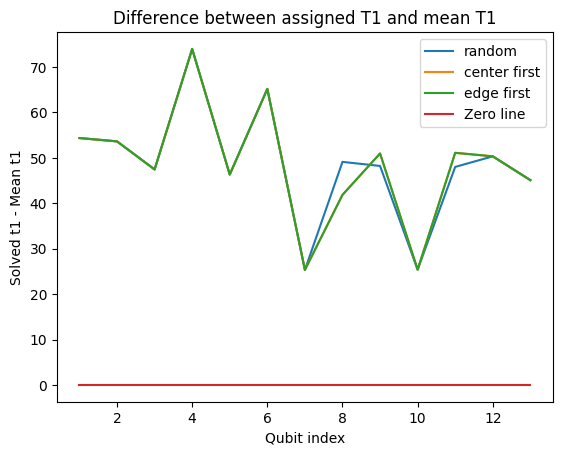

point [[[(np.float64(4.314), np.float64(164.3337888888889))], [(np.float64(4.314), np.float64(164.3337888888889))], [(np.float64(4.314), np.float64(164.3337888888889))]], [[(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))]], [[(np.float64(4.7045), np.float64(162.02167))], [(np.float64(4.7045), np.float64(162.02167))], [(np.float64(4.7045), np.float64(162.02167))]], [[(np.float64(4.4667), np.float64

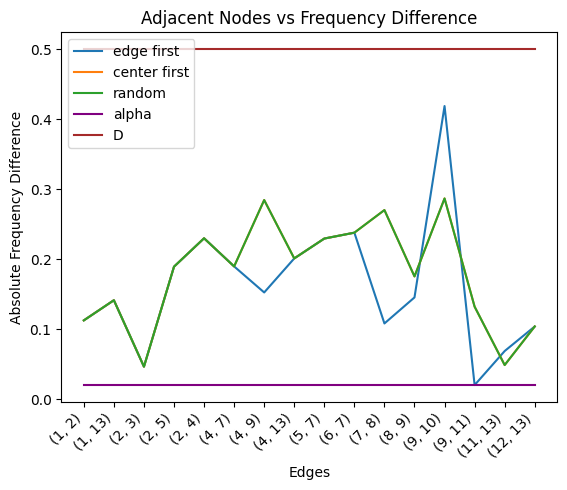

In [20]:
order_list = [None, [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
labels =["random", "center first", "edge first"]
points = run_n_visualize(qdata_smoothed, labels, order_list)

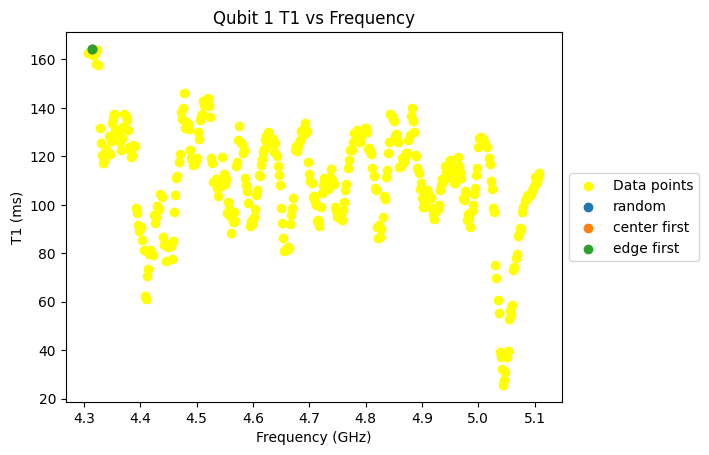

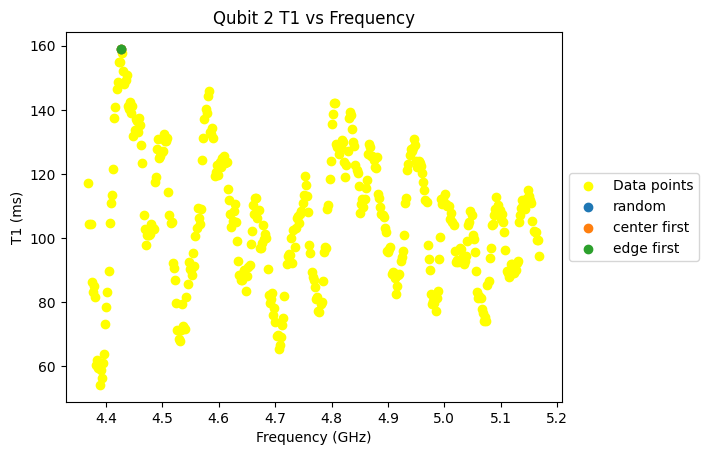

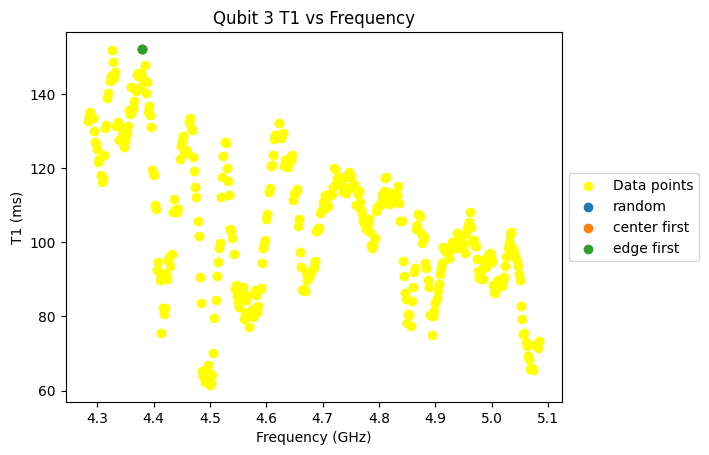

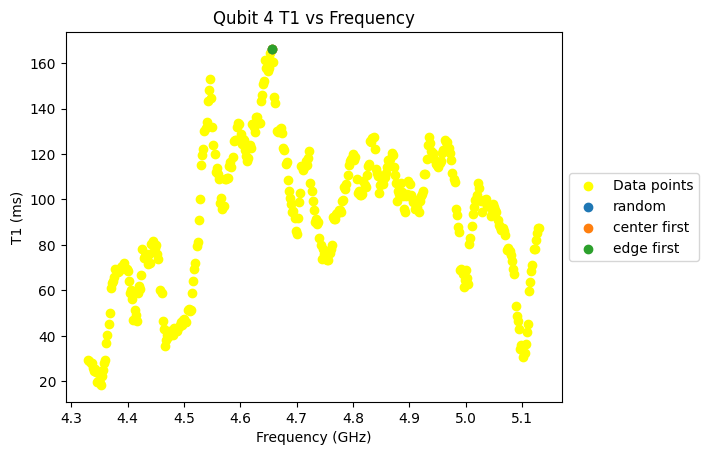

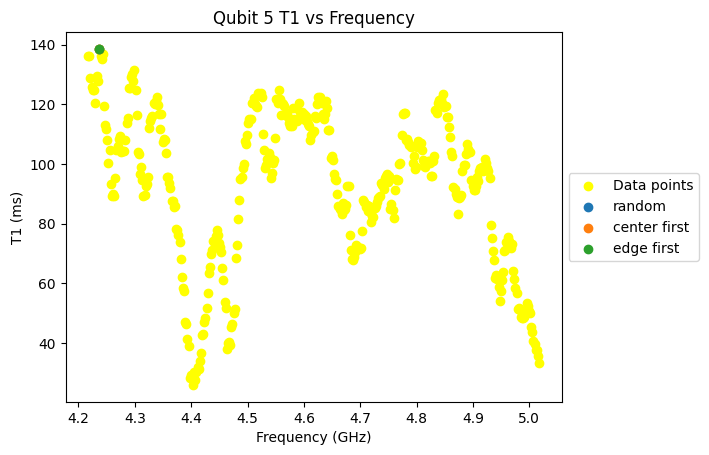

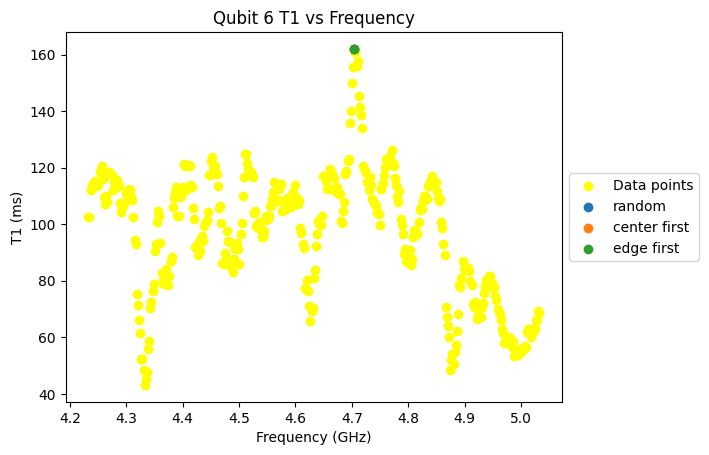

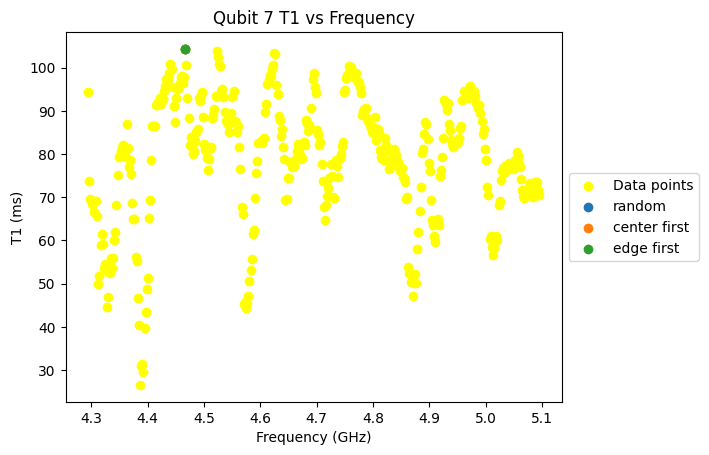

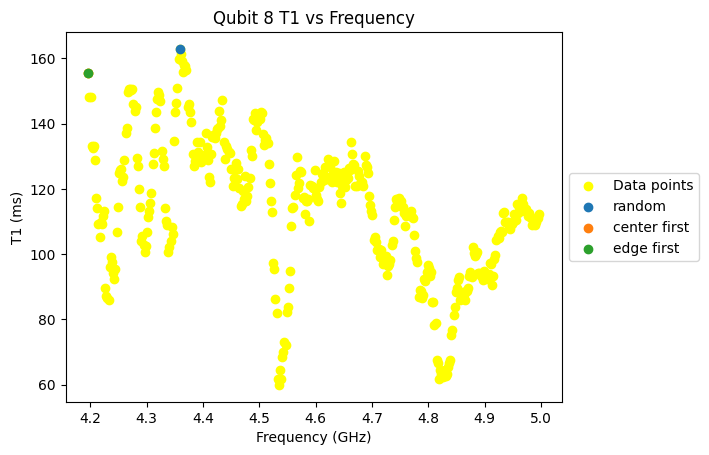

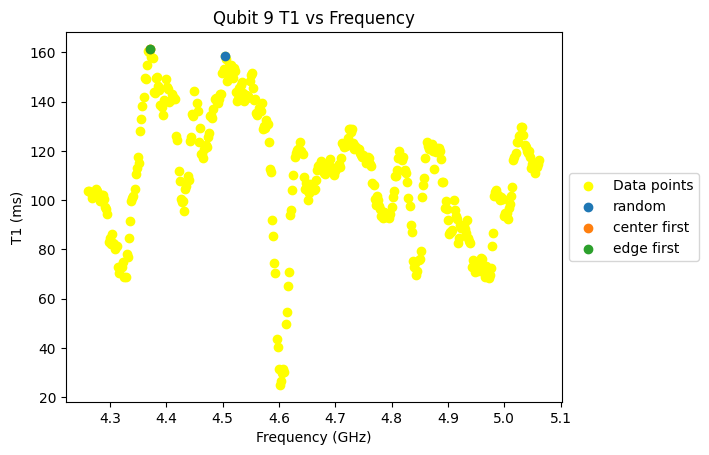

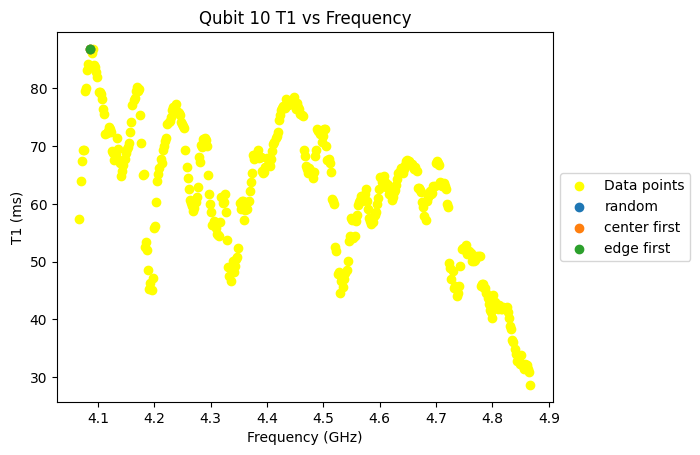

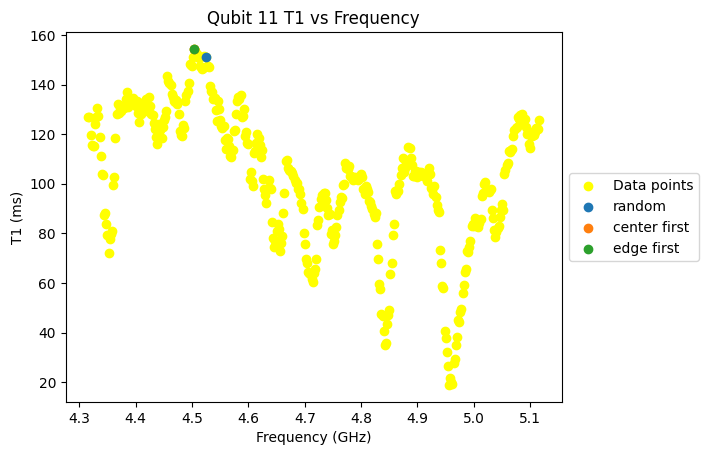

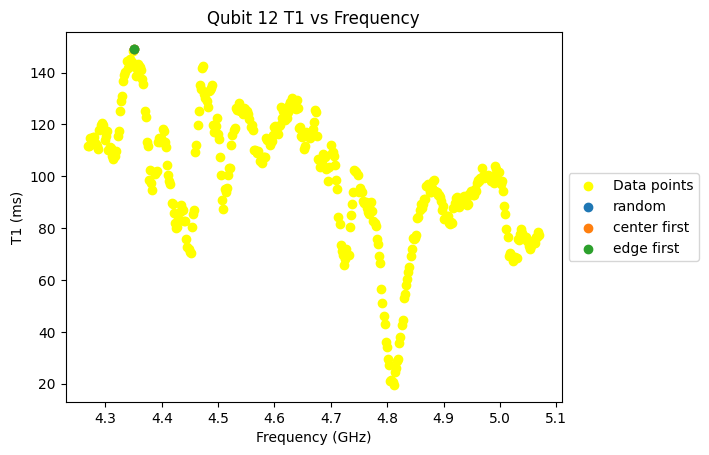

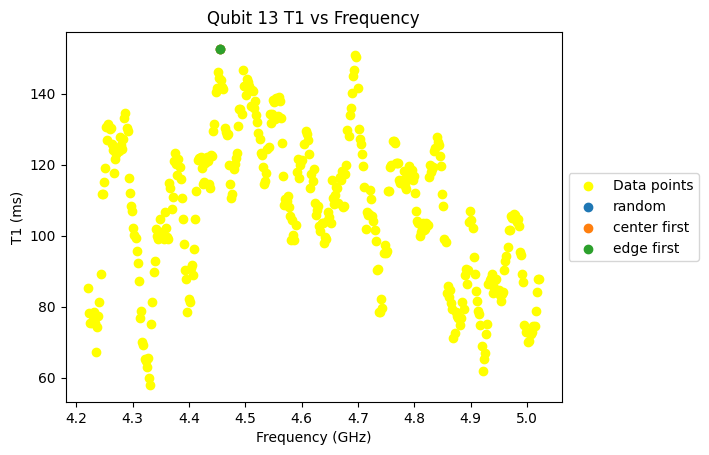

In [21]:
visualize_results(qdata_smoothed, points, labels)

In [18]:
# for i, (freqs, t1s) in (qdata_smoothed.items()):
#     # T1_interp = interp1d(freq, t1, kind='cubic', fill_value='extrapolate')

#     # interp_frequencies = np.linspace(freq.min(), freq.max(), 100)
#     # interp_T1_values = T1_interp(interp_frequencies)

#     plt.scatter(freqs, t1s, color='yellow', label='Data points')
#     plt.title(f'Qubit {i} T1 vs Frequency')

    
#     plt.xlabel('Frequency (GHz)')
#     plt.ylabel('T1 (ms)')
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()